# ViT

paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf)

## setup

In [2]:
import numpy as np
import math
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from enum import Enum, auto
from collections import defaultdict
from IPython.display import HTML
from sklearn.decomposition import PCA
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## helpers

In [3]:
def plot(*args, n_col=None, figsize=None, block_size=3):
    '''Plot images in a grid
    usage: plot(img1, img2, ...)
    optional: n_col=3, figsize=(12, 8), block_size=1

    img: torch.Tensor of shape (H, W) or (C, H, W) or [(H, W), ...] or [(C, H, W), ...]
    '''
    imgs = []
    for img in args:
        if isinstance(img, torch.Tensor):
            if img.dim() == 4: imgs.extend([img[i] for i in range(img.shape[0])])
            else: imgs.append(img)

    # flatten channels
    imgs = [maze.squeeze(0) if maze.dim() == 3 else maze for maze in imgs]
    imgs = [maze.detach().cpu() for maze in imgs]

    if n_col is None: n_col = len(imgs)
    n_row = math.ceil(len(imgs) / n_col)
    if figsize is None: figsize = (n_col * block_size, n_row * block_size)
    # normalize ax to 2d array
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = np.array([[ax]])
    elif n_row == 1: ax = ax.reshape((1, -1))
    elif n_col == 1: ax = ax.reshape((-1, 1))
    # plot
    for i, img in enumerate(imgs):
        idx = (i // n_col, i % n_col)
        ax[idx].imshow(img)
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i // n_col, i % n_col)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        if i >= len(imgs): ax[idx].axis('off')
    plt.tight_layout()
    plt.show()

## data

In [6]:
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=True),
    batch_size=128,
    shuffle=True)

data_test = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=False),
    batch_size=128,
    shuffle=True)

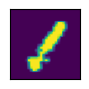

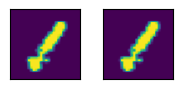

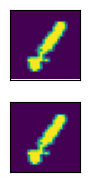

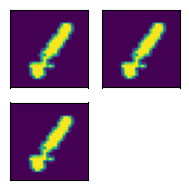

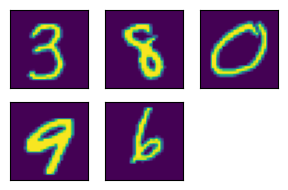

In [10]:
# test plot function
img = next(iter(data))[0][0]
plot(img, block_size=1)
plot(img, img, block_size=1)
plot(img, img, n_col=1, block_size=1)
plot(img, img, img, n_col=2, block_size=1)
imgs = next(iter(data))[0][:5]
plot(imgs, n_col=3, block_size=1)